# GRADED LAB - BIOPSEYE: DETECTING CANCER TUMORS IN MICROSCOPIC IMAGES

The main motivation of this project arises from the existing problem that is cancer which affects to hundreds of thousands of people every year reaching approximately 280.000 cases, according to SEOM (Sociedad Española de Oncología Médica), just in Spain. 

According to an article from www.cancer.gov around 39.5% of people are diagnosed of cancer throughout their life, and according to an article the 53% of people are cured from it.
https://elpais.com/politica/2018/01/29/actualidad/1517229753_900228.html

One of the factors that helps to increment this rate is the fast and early detection of cancer. That is why this project has been carried out. Having an algorithm detect thousands of pictures with a certain accuracy helps experts to detect cases where cancer is found and analyzing them in more depth if needed.

As a result, the aim of this project is to detect potential cases of tumors with given images identifying them either as pictures containing cancer or not. 

For developing this project, 3 data sources will be used: a CSV file containing training labels, a training image data folder and a testing image data folder.

The training and testing image data folders provide a large amount of images named with an ID.

The CSV file has the labels that identify whether a picture from the training folder shows cancer or not, so they are already classified by experts in the field.

The model is trained having as an input the training images and as an output the labels for each ID. The objective of the model is to be able to predict the label for the test data folder images.

A positive label means that the center 32x32px region does contain at least a pixel of tumor tissue, so a pixel of tumor tissue in the outer region will not be taken into account.


Hereunder, the process of the development of the project is described explaining the decisions made and the steps followed.

### Importing libraries

First, the needed libraries are imported, so they are used later in the coding of the model and for processing data.

In [1]:
import tensorflow as tf

import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten

import pandas as pd

### Defining the problem and assembling a dataset

As stated before, the prediction will be a label in which the result will be a 1 or 0 if the image is classified as cancer or not, respectively. So, in short, the problem being faced is a binary classification one.

In [2]:
df = pd.read_csv('./data/train_labels.csv')

print(df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


As it can be seen below, the data is a little unbalanced, so later on more synthetic images will be created from the ones existing.

<AxesSubplot:xlabel='label', ylabel='count'>

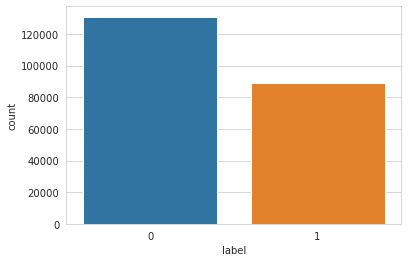

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])

In [4]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [5]:
df['label'] = df['label'].apply(lambda x: str(x))

In [6]:
print(len(df))

220025


In [7]:
train_path = "./data/train"
#test= './data/test'
print(len(os.listdir(train_path)))

220025


As it is shown below, the images have a shape of 96x96px with three dimensions that represent the colours.

In [8]:
train_img = plt.imread('./data/train/' + df.iloc[0]['id'] + '.tif')

print('Image Shape:', train_img.shape)

Image Shape: (96, 96, 3)


0


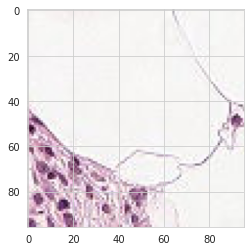

1


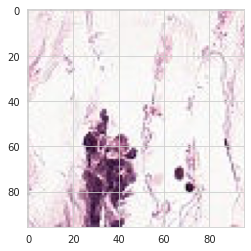

0


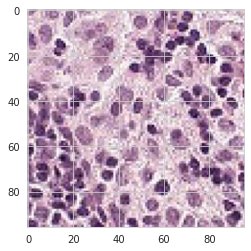

0


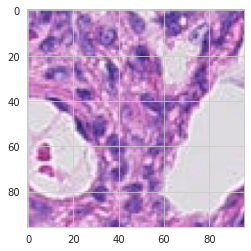

0


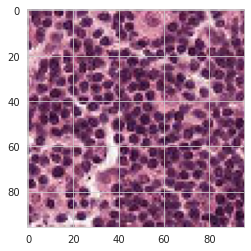

In [9]:
for i in range(5):
    train_img = plt.imread('./data/train/' + df.iloc[i]['id'] + '.tif')
    print(df.iloc[i]['label'])
    plt.imshow(train_img)
    plt.show()

As the data amount is quite big, it is divided into training and validation datasets. Having the 20% of the total amount for validation and the rest for training.

In [10]:
y = df['label']
from sklearn.model_selection import train_test_split

trainx, valx = train_test_split(df, test_size=0.2, random_state=99, stratify=y)
print(trainx.shape)
print(valx.shape)
print(trainx['label'].value_counts())
print(valx['label'].value_counts())

print(len(trainx['id']))
print(len(valx['id']))

(176020, 2)
(44005, 2)
0    104726
1     71294
Name: label, dtype: int64
0    26182
1    17823
Name: label, dtype: int64
176020
44005


In [11]:
train_path = './data/train'
valid_path = './data/train'

In [12]:
df['id'] = df['id'].apply(lambda x: x + '.tif')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


ImageDataGenerator library from Keras is used for Data Augmentation, with which new samples are generated.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x)


With the parameter `rescale` the data is normalized dividing all the values by the largest pixel value, 255, so that all of them are ranged between 0 and 1.


Parameters like `horizontal_flip`, `vertical_flip`, `brightness_range`, `rotation_range` and `zoom_range` transform original samples and create new ones applying these changes, without changing the label.

In [14]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='reflect',
    rotation_range=15,
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

In [15]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='id',
    y_col='label',
    batch_size=64,
    shuffle=True,
    subset='training',
    seed=2020,
    class_mode='binary',
    target_size=(96, 96)
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=df,
    directory=valid_path,
    x_col='id',
    y_col='label',
    batch_size=32,
    shuffle=False,
    subset='validation',
    seed=2020,
    class_mode='binary',
    target_size=(96, 96))

test_generator = data_generator.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='id',
    y_col='label',
    batch_size=32,
    shuffle=False,
    subset='validation',
    seed=2020,
    class_mode='binary',
    target_size=(96, 96))



Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Finally, three datasets are generated, train, test and validation. Validation will be used in the training phase of the model so that the loss is calculated and the performance of the model in each epoch can be measured.

All the labels will be classified identifying the ones as tumor samples and zeros as healthy ones.

In [16]:
train_generator.class_indices['0'] = 'No Tumor'
train_generator.class_indices['1'] = 'Tumor'
train_generator.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [17]:
validation_generator.class_indices['0'] = 'No Tumor'
validation_generator.class_indices['1'] = 'Tumor'
validation_generator.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [18]:
test_generator.class_indices['0'] = 'No Tumor'
test_generator.class_indices['1'] = 'Tumor'
test_generator.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

### Creating the CNN model

The generated model is a Convolutional Neural Network. The input size, as stated before, is 96, 96, 3, where 96x96 is the size in pixels of each image and 3 the channels of colors RGB. 

The model is composed of four convolutional layers composed by the same architecture: Conv2D, MaxPooling2D and Dropout. In each one the filters of each layer is defined. The first one has 16 filters and is activated using Rectified Linear unit (ReLU). This function results in the same positive value when positive and zero if negative.

Batch normalization is used for stabilizing the neural network substracting the batch mean and dividing by the batch standard deviation.

Using Dropout and MaxPooling prevent the model from overfitting.

In the end, the Flatten function is used to reduce the 2D layer into 1D. This layer is treated as a flat layer with 256 units. Dropout is used again to prevent overfitting and finally, another Dense layer is added where the result is a single unit calculated with sogmoid function where the output is either 0 or 1.

In [19]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(96, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

2022-05-18 21:30:21.322451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 21:30:21.363763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 21:30:21.364103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 21:30:21.365281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                        

### Training the CNN model

As it can be seen below, the metric used for evaluation is accuracy, which is defined as the number of classifications a model correctly predicts divided by the total number of predictions made. 

The optimizer chosen is Adam with a learning rate of 0.001 and the loss function chosen is binary_crossentropy as the output needed is 0 or 1.

In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

`EarlyStopping` from Keras stops training when the metric evaluated does not get any better, in this case validation loss. Patience is the numeber of epochs with no imrpovement after which the model stops training.

`ReduceLROnPlateau` from Keras is used for reducing the learning rate when the metric stops getting better. In this case the metric evaluated is validation loss.

Fit_generator function is used for fitting the model because the dataset is quite large to fit into memory and supports data augmentation.

In [23]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    mode='max',
    restore_best_weights=True)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    verbose=1,
    mode='max',
    factor=0.1,
    min_lr=0.001)

In [24]:
cnn_history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=20,
    callbacks=[earlystop, reduce])

Epoch 1/20


2022-05-18 21:30:25.257870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-05-18 21:30:26.035420: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-18 21:30:26.035986: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-18 21:30:26.036018: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-05-18 21:30:26.036626: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-18 21:30:26.036700: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2750/2750 [==============================] - 612s 221ms/step - loss: 0.4583 - accuracy: 0.7911 - val_loss: 0.4295 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 2/20
2750/2750 [==============================] - 541s 197ms/step - loss: 0.3660 - accuracy: 0.8418 - val_loss: 0.5491 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 3/20
2750/2750 [==============================] - 529s 192ms/step - loss: 0.3220 - accuracy: 0.8648 - val_loss: 0.3273 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 4/20
2750/2750 [==============================] - 527s 192ms/step - loss: 0.2950 - accuracy: 0.8787 - val_loss: 0.5179 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 00004: early stopping


As seen, the model stops training after the fourth epoch as the validation loss does not get better.

In [25]:
model.metrics_names

['loss', 'accuracy']

In [26]:
train_generator.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

### Evaluating the CNN model

The values of loss and accuracy of the validation subset are printed below, so the performance can be evaluated.

In [27]:
val_loss, val_acc = model.evaluate(test_generator,
                                   steps=STEP_SIZE_TEST)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

1375/1375 [==============================] - 101s 74ms/step - loss: 0.5518 - accuracy: 0.7444
val_loss: 0.5517824292182922
val_acc: 0.7443863749504089


<Figure size 432x288 with 0 Axes>

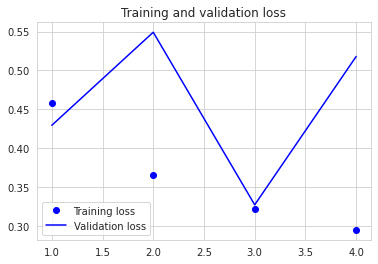

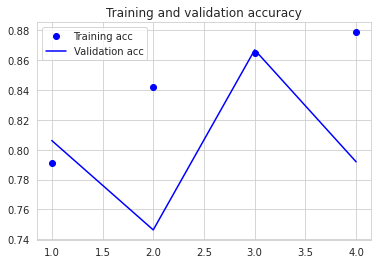

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

The results plotted show that the validation accuracy does not get much better after the second epoch and the loss does get higher, meaning it overfits. 

Finally, the model is saved in H5 format.

In [29]:
import time

t = time.time()
export = './models/cnn/{}.h5'.format(int(t))
print(export)

model.save(export)

./models/cnn/1652904534.h5


In [30]:
t = time.time()
export_tf = "./models/cnn/{}".format(int(t))
print(export_tf)
tf.saved_model.save(model, export_tf)

./models/cnn/1652904534


2022-05-18 22:08:55.820144: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/cnn/1652904534/assets


# Alternative model with VGG16

### Creating the VGG16 model

It has been decided to carry out a second model using VGG16 to see if the performance get any better.

The input shape as for the previous model is 96, 96, 3. The model does already have layers predefined so there is no need to define them.

Each layer is composed of two Conv2D layers and one MaxPooling2D. There are 5 layers in total.

In [31]:
base_model = tf.keras.applications.VGG16(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

As the output has to be a single value (either 0 or 1) the size is reduced to 1D using Flatten as before and adding three Dense layers. Using sigmoid as its better when dealing with binary classification.

Dropout and BatchNormalization are also used for overfitting issues.

In [32]:
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)

vgg16 = Sequential([
    base_model,
    BatchNormalization(),

    Flatten(),

    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 batch_normalization_8 (Batc  (None, 3, 3, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                73744     
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                      

### Training the VGG16 model

As for the previous model, Adam is chosen for the optimizer with 0,001 learning rate, and binary_crossentropy for the two classes.

In [33]:
opt = tf.keras.optimizers.Adam(0.001)
vgg16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [34]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df.label)

In [35]:
%%time

vgg16_history = vgg16.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=20,
    callbacks=[earlystop, reduce])

Epoch 1/20
2750/2750 [==============================] - 678s 243ms/step - loss: 0.4937 - accuracy: 0.7679 - auc: 0.8360 - val_loss: 0.3915 - val_accuracy: 0.8254 - val_auc: 0.9005 - lr: 0.0010
Epoch 2/20
2750/2750 [==============================] - 661s 240ms/step - loss: 0.4597 - accuracy: 0.7934 - auc: 0.8631 - val_loss: 0.3869 - val_accuracy: 0.8305 - val_auc: 0.9044 - lr: 0.0010
Epoch 3/20
2750/2750 [==============================] - 673s 245ms/step - loss: 0.4545 - accuracy: 0.7955 - auc: 0.8662 - val_loss: 0.3838 - val_accuracy: 0.8288 - val_auc: 0.9061 - lr: 0.0010
Epoch 00003: early stopping
CPU times: user 30min 49s, sys: 39.1 s, total: 31min 28s
Wall time: 33min 32s


### Evaluating the VGG16 model

The values of loss, accuracy and AUC (Area Under Curve) of the validation subset are printed below, so the performance can be evaluated.

In [41]:
val_loss, val_acc, auc = vgg16.evaluate(test_generator,
                                        steps=STEP_SIZE_TEST)

print('val_loss:', val_loss)
print('val_acc:', val_acc)
print('auc:', auc)

1375/1375 [==============================] - 150s 109ms/step - loss: 0.3928 - accuracy: 0.8251 - auc: 0.8990
val_loss: 0.39282697439193726
val_acc: 0.8250681757926941
auc: 0.8990498185157776


<Figure size 432x288 with 0 Axes>

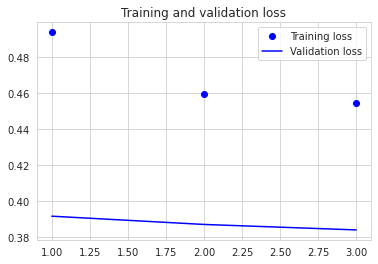

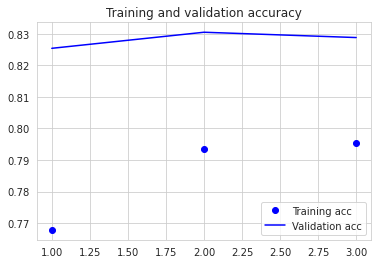

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

As it can be seen, the validation metrics are lower for this model than for the previous one. 

Reduce and early stopping are also used to stop the training if the metric does not get better. This model stops training after the third as it does not get better results.

In [39]:
import time

t = time.time()
export = './models/vgg16/{}.h5'.format(int(t))
print(export)

vgg16.save(export)

./models/vgg16/1652906867.h5


In [40]:
t = time.time()
export_tf = "./models/vgg16/{}".format(int(t))
print(export_tf)
tf.saved_model.save(vgg16, export_tf)

./models/vgg16/1652906867
INFO:tensorflow:Assets written to: ./models/vgg16/1652906867/assets


### Conclusion

As it has been shown in the study above, from the comparison of the two models, better results are scored with the CNN model than with VGG16 model. A summary of the comparisons is shown in a table here below:

|                     | CNN   | VGG16 |
|---------------------|-------|-------|
| Validation loss     | 0.327 | 0.384 |
| Validation accuracy | 0.867 | 0.83  |

All in a nutshell, the model chosen as BIOPSEYE official solution is CNN.